In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt1

In [2]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt1.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt1.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propyes_by_condition, rt_by_condition = analyze_expt1.get_perf_by_cond()


In [7]:
super_inds_long

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

#### Plotting params

In [4]:
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255
point_types = ['o','x']
markersize = 4;
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

#### d-prime values: two-way repeated measures anova, all subjects

In [4]:
vals = dprime_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(47, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             157.527146     1.0    46.0  1.846486e-16
image_type       318.804240     4.0   184.0  1.495658e-81
cond:image_type    6.098708     4.0   184.0  1.248537e-04


#### t-tests comparing basic vs superordinate, within image type

In [5]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = dprime_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
# df['p'] = pvals
        
df        
    

All subjects:
(47, 2, 5)


,t (basic-super),p
pool1,-3.1493,0.008
pool2,-8.4729,0.000
pool3,-7.9762,0.000
pool4,-8.6022,0.000
orig,-4.0648,0.000


#### plot dprime, all subjects

Text(0.5, 1.0, 'All subjects (n=47)')

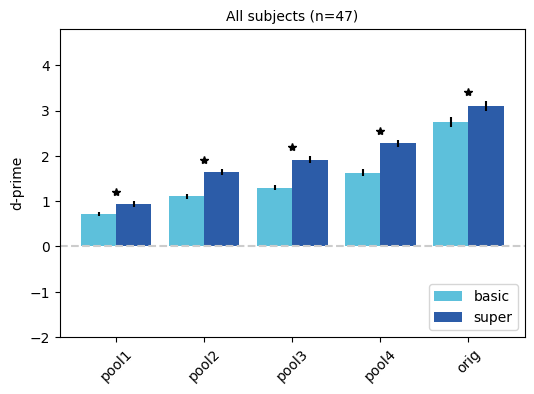

In [6]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = dprime_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='lower right')

plt.ylabel('d-prime')

plt.ylim([-2, 4.8])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [10]:
pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)

# averaging across basic/super conds here
vals = np.mean(dprime_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df   

,t,p
pool1 vs pool2,-8.7929,0.0
pool1 vs pool3,-16.5999,0.0
pool1 vs pool4,-21.3852,0.0
pool1 vs orig,-26.7930,0.0
pool2 vs pool3,-4.2456,0.0
pool2 vs pool4,-10.6960,0.0
pool2 vs orig,-20.0879,0.0
pool3 vs pool4,-8.0408,0.0
pool3 vs orig,-17.7029,0.0
pool4 vs orig,-15.5630,0.0


#### d-prime: separate out the two image sets

In [11]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(23, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              56.038358     1.0    22.0  1.746264e-07
image_type       226.967369     4.0    88.0  1.779504e-45
cond:image_type    4.780470     4.0    88.0  1.547922e-03

Image set 2:
(24, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             123.342781     1.0    23.0  1.019530e-10
image_type       170.458059     4.0    92.0  1.188119e-41
cond:image_type    7.576509     4.0    92.0  2.540961e-05


#### t-tests comparing basic vs superordinate, within image type

In [12]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(23, 2, 5)

Image set 2:
(24, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-0.9287,0.328,-4.0907,0.00
pool2,-6.4365,0.000,-5.7580,0.00
pool3,-5.4907,0.000,-6.2350,0.00
pool4,-5.0015,0.000,-7.4858,0.00
orig,-4.7103,0.000,-1.1616,0.28


#### plot d-prime for each image set

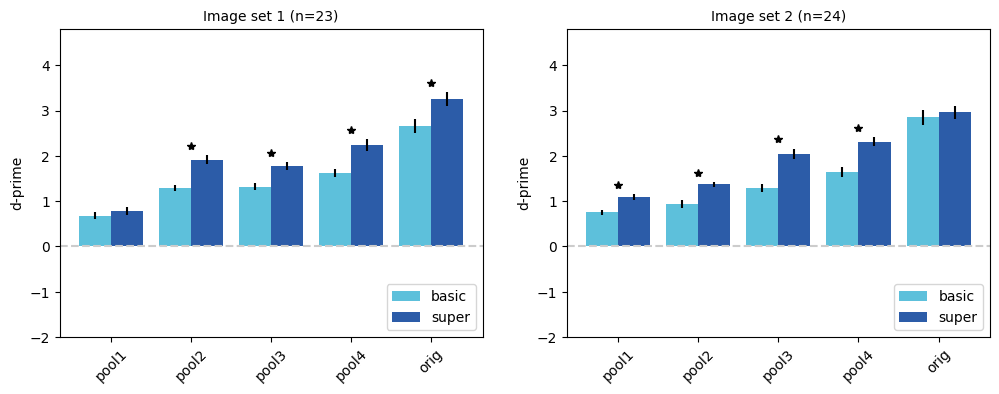

In [13]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='lower right')
    
    plt.ylabel('d-prime')
    
    plt.ylim([-2, 4.8])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Analyze RTs

In [22]:
vals = rt_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)


All subjects:
(47, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.506619     1.0    46.0  4.802003e-01
image_type       20.817284     4.0   184.0  3.598866e-14
cond:image_type   6.777234     4.0   184.0  4.133448e-05


#### compare basic vs superordinate, within image type

In [15]:
tvals = np.zeros((5,))
pvals = np.zeros((5,))

df = pd.DataFrame(index=image_type_names)

vals = rt_by_condition

print('All subjects:')
print(vals.shape)

for ii in range(n_image_types):

    p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])

    tvals[ii] = t
    pvals[ii] = p

df['t (basic-super)'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
        
df        
    

All subjects:
(47, 2, 5)


,t (basic-super),p
pool1,-3.1866,0.035
pool2,-0.5013,0.630
pool3,0.4856,0.630
pool4,2.3779,0.035
orig,-0.9905,0.590


#### plot RTs, all subjects

Text(0.5, 1.0, 'All subjects (n=47)')

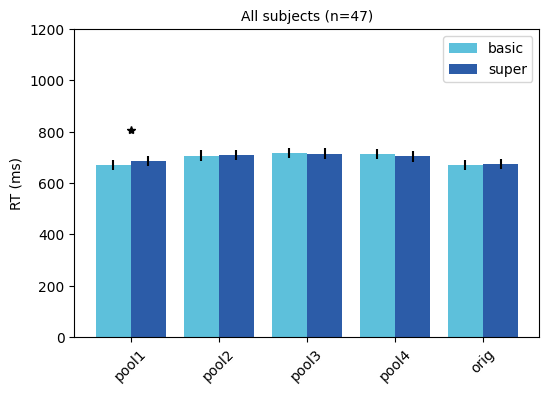

In [16]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = rt_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+100
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

# plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('RT (ms)')

plt.ylim([0, 1200])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [17]:

pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)


# averaging across basic/super conds here
vals = np.mean(rt_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr


df   

,t,p
pool1 vs pool2,-6.7693,0.000000
pool1 vs pool3,-6.3778,0.000000
pool1 vs pool4,-4.4570,0.000000
pool1 vs orig,0.6161,0.602222
pool2 vs pool3,-2.2962,0.048571
pool2 vs pool4,-0.2111,0.894000
pool2 vs orig,4.5514,0.000000
pool3 vs pool4,1.9079,0.052500
pool3 vs orig,6.0222,0.000000
pool4 vs orig,6.5087,0.000000


#### RTs: separate out the two image sets

In [18]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


Image set 1:
(23, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.661379     1.0    22.0  4.247879e-01
image_type       10.887246     4.0    88.0  3.232715e-07
cond:image_type   5.236051     4.0    88.0  7.872182e-04

Image set 2:
(24, 2, 5)
                  F Value  Num DF  Den DF        Pr > F
cond             0.033685     1.0    23.0  8.559876e-01
image_type       9.935680     4.0    92.0  9.984449e-07
cond:image_type  2.046934     4.0    92.0  9.425691e-02


In [19]:
tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    for ii in range(n_image_types):
        
        p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii])
        
        tvals[cbi, ii] = t
        pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]

df


Image set 1:
(23, 2, 5)

Image set 2:
(24, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-4.0344,0.00,-1.2467,0.565
pool2,-0.6326,0.77,-0.0495,0.954
pool3,0.4623,0.77,0.2143,0.954
pool4,1.5163,0.48,1.8470,0.330
orig,-0.5885,0.77,-0.8676,0.770


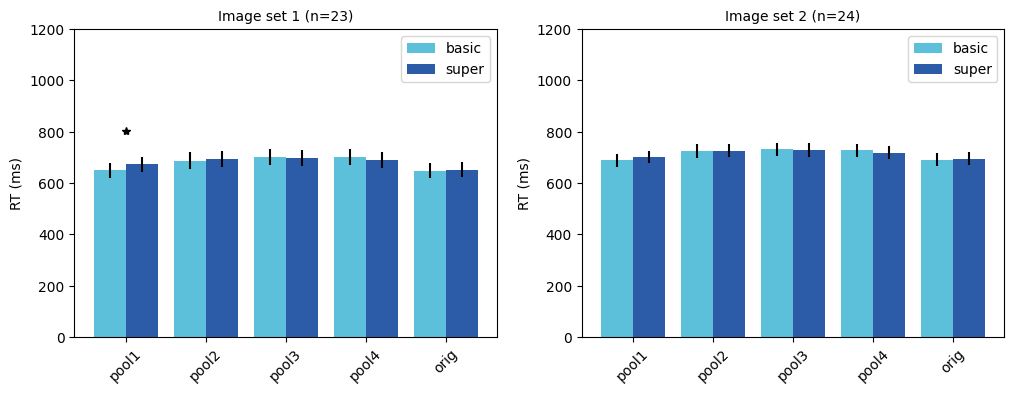

In [20]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = rt_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+100
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    # plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='upper right')
    
    plt.ylabel('RT (ms)')
    
    plt.ylim([0, 1200])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### pairwise comparisons across image types

In [21]:

for cbi, cb in enumerate([1,2]):
        
    pairs_test = list(itertools.combinations(np.arange(5),2))
    n_pairs = len(pairs_test)
    pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]
    
    tvals = np.zeros((n_pairs))
    pvals = np.zeros((n_pairs))
    
    df = pd.DataFrame(index=pair_names)
    
    
    # averaging across basic/super conds here
    vals = np.mean(rt_by_condition[subject_cb==cbi,:,:], axis=1)

    print(vals.shape)
    for pi, pair in enumerate(pairs_test):
    
        vals1 = vals[:,pair[0]]
        vals2 = vals[:,pair[1]]
    
        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2)
    
        tvals[pi] = t
        pvals[pi] = p
    
    df['t'] = tvals.round(4)
    
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
    df['p'] = pvals_fdr
    
    print('image set %d'%cb)
    print(df)   

(23, 5)
image set 1
                     t         p
pool1 vs pool2 -4.0162  0.003333
pool1 vs pool3 -4.5219  0.000000
pool1 vs pool4 -3.1931  0.003333
pool1 vs orig   0.7416  0.504000
pool2 vs pool3 -2.4963  0.020000
pool2 vs pool4 -0.9804  0.387500
pool2 vs orig   3.3451  0.003333
pool3 vs pool4  0.7653  0.504000
pool3 vs orig   4.2859  0.000000
pool4 vs orig   4.7520  0.000000
(24, 5)
image set 2
                     t         p
pool1 vs pool2 -5.6738  0.000000
pool1 vs pool3 -4.4051  0.000000
pool1 vs pool4 -3.0512  0.000000
pool1 vs orig   0.0842  0.970000
pool2 vs pool3 -1.0279  0.357500
pool2 vs pool4  0.5243  0.646667
pool2 vs orig   3.0283  0.006667
pool3 vs pool4  1.9473  0.100000
pool3 vs orig   4.2231  0.000000
pool4 vs orig   4.6755  0.000000


Text(0.5, 1.0, 'All subjects (n=47)')

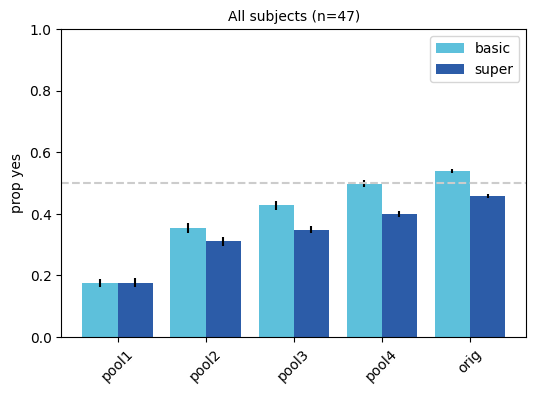

In [7]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = propyes_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    # if pvals[ii]<0.01:
    #     height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
    #     plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('prop yes')

plt.ylim([0, 1.0])

plt.title('All subjects (n=%d)'%(n_subs_plot))